In [1]:
# Plotting
%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt

import warnings; 
warnings.simplefilter('ignore')

from datetime import datetime
import pandas as pd
import numpy as np

# Normalization
from sklearn.preprocessing import MinMaxScaler

# Deep Learing
import keras
import itertools
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, GRU
from keras.utils import to_categorical
from keras.optimizers import Adam 
from keras.callbacks import History, TerminateOnNaN, ReduceLROnPlateau, EarlyStopping
from keras.utils import np_utils
from keras import backend as K

plt.rcParams['figure.figsize'] = (20.0, 10.0)

Using TensorFlow backend.


In [2]:
df = pd.read_csv("data_v2.csv")

In [3]:
df.head()

,LCLid,stdorToU,DateTime,KWH/hh (per half hour),Acorn,Acorn_grouped
0,MAC000002,Std,2013-01-01 00:00:00,0.219,ACORN-A,Affluent
1,MAC000002,Std,2013-01-01 00:30:00,0.241,ACORN-A,Affluent
2,MAC000002,Std,2013-01-01 01:00:00,0.191,ACORN-A,Affluent
3,MAC000002,Std,2013-01-01 01:30:00,0.235,ACORN-A,Affluent
4,MAC000002,Std,2013-01-01 02:00:00,0.182,ACORN-A,Affluent


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45858295 entries, 0 to 45858294
Data columns (total 6 columns):
LCLid                      object
stdorToU                   object
DateTime                   object
KWH/hh (per half hour)     float64
Acorn                      object
Acorn_grouped              object
dtypes: float64(1), object(5)
memory usage: 2.1+ GB


In [5]:
df = df.rename({'KWH/hh (per half hour) ': 'KWh'}, axis=1)

In [6]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [7]:
feature_date_time = df.groupby('DateTime')['KWh'].agg(['mean'])

In [8]:
feature_date_time.head()

,mean
DateTime,
2013-01-01 00:00:00,0.240512
2013-01-01 00:30:00,0.221784
2013-01-01 01:00:00,0.204738
2013-01-01 01:30:00,0.187682
2013-01-01 02:00:00,0.170383


In [9]:
feature_date_time = feature_date_time.rename(columns={'mean':'Avg_KWh'})

In [10]:
h_params = {'n_in': 24, 'n_out': 24, 'step_foreward': 24, 'column_value': 'Avg_KWh'}
date_train =  datetime.strptime('2013-10-02 23:30:00', '%Y-%m-%d %H:%M:%S')

In [11]:
df_train = feature_date_time[feature_date_time.index <= date_train]
df_test = feature_date_time[feature_date_time.index > date_train]

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13200 entries, 2013-01-01 00:00:00 to 2013-10-02 23:30:00
Data columns (total 1 columns):
Avg_KWh    13200 non-null float64
dtypes: float64(1)
memory usage: 206.2 KB


In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))

# train the scaler on the training data
scaler.fit(df_train[[h_params['column_value']]])
df_train[[h_params['column_value']]] = scaler.transform(df_train[[h_params['column_value']]])
df_test[[h_params['column_value']]] = scaler.transform(df_test[[h_params['column_value']]])
df_train.describe()

,Avg_KWh
count,13200.000000
mean,0.298474
std,0.191633
min,0.000000
25%,0.161982
50%,0.274207
75%,0.403862
max,1.000000


In [14]:
df_test.describe()

,Avg_KWh
count,4320.000000
mean,0.346908
std,0.208946
min,0.003737
25%,0.183376
50%,0.332011
75%,0.498083
max,0.814432


In [15]:
def create_x_tensors(data, n_in, dropNaN=True):
    """
    Creates X tensors for LSTM time series prediction
    Output has shape (samples, timesteps, features)
    """
    # create lagged variables
    cols = list()
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
    lagged_df = pd.concat(cols, axis=1)
    if dropNaN:
        lagged_df.dropna(inplace=True)

    # reshape data to shape [samples, timesteps, features]
    return lagged_df.values.reshape((lagged_df.shape[0], n_in, n_features))


def create_y_tensor(data, n_out=1, dropNaN=True):
    """
    Creates Y tensor for LSTM time series prediction
    """
    dff = pd.DataFrame(data)
    cols = list()
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
    lagged_df = pd.concat(cols, axis=1)
    if dropNaN:
        lagged_df.dropna(inplace=True)

    # reshape data to shape [samples, timesteps]
    return lagged_df.values.reshape((lagged_df.shape[0], n_out))


def prepare_data(data, n_in, n_out, step_foreward):
    df = pd.DataFrame(data)

    # check steps and cut data at the beginning
    timesteps = df.shape[0]
    steps = int((timesteps - n_in - n_out) / step_foreward)
    nDrop = timesteps - (steps * n_out + n_in + n_out)
    if nDrop > 0:
        df = df[nDrop:]
    return df


def create_tensors(data, column_value, n_in=1, n_out=1, step_foreward=1, dropNaN=True):
    n_features = data.shape[1]
    df = pd.DataFrame(data)

    # X tensor
    cols = list()
    dfX = df[column_value][:-n_out]
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
    lagged_df = pd.concat(cols, axis=1)
    if dropNaN:
        lagged_df.dropna(inplace=True)
    # reshape data to shape [samples, timesteps, features]
    tensor_X = lagged_df.values.reshape((lagged_df.shape[0], n_in, n_features))
    tensor_X = tensor_X[range(0, tensor_X.shape[0], step_foreward)]

    # y tensor
    cols = list()
    dfY = df[column_value][n_in:]
    for i in range(0, n_out):
        cols.append(dfY.shift(-i))
    lagged_df = pd.concat(cols, axis=1)
    if dropNaN:
        lagged_df.dropna(inplace=True)
    # reshape data to shape [samples, timesteps]
    tensor_y = lagged_df.values.reshape((lagged_df.shape[0], n_out))
    tensor_y = tensor_y[range(0, tensor_y.shape[0], step_foreward)]

    return tensor_X, tensor_y

In [16]:
train_X, train_y = create_tensors(df_train, h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])
train_X.shape

(549, 24, 1)

In [17]:
def keras_model(dropout_rate):
    model = Sequential()
    model.add(Dropout(dropout_rate, input_shape=(train_X.shape[1], train_X.shape[2])))
    gru = GRU(256, recurrent_dropout=0.3)
    model.add(gru)
    model.add(Dropout(dropout_rate))
    model.add(Dense(128))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128))
    model.add(Dense(h_params['n_out']))
    return model

In [18]:
model = keras_model(dropout_rate=0.2)
model.compile(loss='mae', optimizer=Adam(), metrics=['accuracy'])

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 24, 1)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               198144    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

In [20]:
history = History()
nan_terminator = TerminateOnNaN()
early_stopping = EarlyStopping(patience=10, 
                               verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='loss', 
                              factor=0.5, 
                              patience=50, 
                              verbose=1, 
                              mode='auto', 
                              epsilon=0.0001, 
                              cooldown=0, 
                              min_lr=1e-8)

history = model.fit(train_X, train_y, epochs=500, batch_size=250, validation_split=0.25, verbose=1, shuffle=True,
                    callbacks=[history, nan_terminator, reduce_lr])

Train on 411 samples, validate on 138 samples
Epoch 1/500
411/411 [==============================] - 5s 13ms/step - loss: 0.3083 - acc: 0.0292 - val_loss: 0.1730 - val_acc: 0.0000e+00
Epoch 2/500
411/411 [==============================] - 0s 902us/step - loss: 0.2343 - acc: 0.0122 - val_loss: 0.1227 - val_acc: 0.0435
Epoch 3/500
411/411 [==============================] - 0s 894us/step - loss: 0.1798 - acc: 0.0341 - val_loss: 0.1201 - val_acc: 0.0072
Epoch 4/500
411/411 [==============================] - 0s 905us/step - loss: 0.1715 - acc: 0.1071 - val_loss: 0.0992 - val_acc: 0.1812
Epoch 5/500
411/411 [==============================] - 0s 845us/step - loss: 0.1603 - acc: 0.1168 - val_loss: 0.0955 - val_acc: 0.0362
Epoch 6/500
411/411 [==============================] - 0s 863us/step - loss: 0.1556 - acc: 0.1119 - val_loss: 0.0916 - val_acc: 0.0362
Epoch 7/500
411/411 [==============================] - 0s 807us/step - loss: 0.1462 - acc: 0.1071 - val_loss: 0.0905 - val_acc: 0.1087
Epoch 

Epoch 61/500
411/411 [==============================] - 0s 828us/step - loss: 0.0956 - acc: 0.1509 - val_loss: 0.0602 - val_acc: 0.0797
Epoch 62/500
411/411 [==============================] - 0s 852us/step - loss: 0.0962 - acc: 0.1752 - val_loss: 0.0643 - val_acc: 0.0725
Epoch 63/500
411/411 [==============================] - 0s 868us/step - loss: 0.0955 - acc: 0.1363 - val_loss: 0.0556 - val_acc: 0.0362
Epoch 64/500
411/411 [==============================] - 0s 849us/step - loss: 0.0997 - acc: 0.1582 - val_loss: 0.0603 - val_acc: 0.0435
Epoch 65/500
411/411 [==============================] - 0s 852us/step - loss: 0.0921 - acc: 0.1387 - val_loss: 0.0712 - val_acc: 0.0725
Epoch 66/500
411/411 [==============================] - 0s 852us/step - loss: 0.0926 - acc: 0.1679 - val_loss: 0.0519 - val_acc: 0.1232
Epoch 67/500
411/411 [==============================] - 0s 833us/step - loss: 0.0922 - acc: 0.0973 - val_loss: 0.0557 - val_acc: 0.1232
Epoch 68/500
411/411 [==========================

411/411 [==============================] - 0s 811us/step - loss: 0.0795 - acc: 0.1411 - val_loss: 0.0514 - val_acc: 0.0217
Epoch 122/500
411/411 [==============================] - 0s 836us/step - loss: 0.0766 - acc: 0.1484 - val_loss: 0.0533 - val_acc: 0.0942
Epoch 123/500
411/411 [==============================] - 0s 810us/step - loss: 0.0772 - acc: 0.1168 - val_loss: 0.0487 - val_acc: 0.1232
Epoch 124/500
411/411 [==============================] - 0s 863us/step - loss: 0.0791 - acc: 0.1241 - val_loss: 0.0494 - val_acc: 0.1232
Epoch 125/500
411/411 [==============================] - 0s 828us/step - loss: 0.0813 - acc: 0.1436 - val_loss: 0.0514 - val_acc: 0.1159
Epoch 126/500
411/411 [==============================] - 0s 839us/step - loss: 0.0774 - acc: 0.1825 - val_loss: 0.0574 - val_acc: 0.0362
Epoch 127/500
411/411 [==============================] - 0s 826us/step - loss: 0.0788 - acc: 0.1484 - val_loss: 0.0499 - val_acc: 0.0362
Epoch 128/500
411/411 [==============================] 

Epoch 181/500
411/411 [==============================] - 0s 809us/step - loss: 0.0690 - acc: 0.1509 - val_loss: 0.0456 - val_acc: 0.1449
Epoch 182/500
411/411 [==============================] - 0s 851us/step - loss: 0.0693 - acc: 0.1800 - val_loss: 0.0417 - val_acc: 0.1159
Epoch 183/500
411/411 [==============================] - 0s 809us/step - loss: 0.0669 - acc: 0.1727 - val_loss: 0.0480 - val_acc: 0.1232
Epoch 184/500
411/411 [==============================] - 0s 811us/step - loss: 0.0671 - acc: 0.1606 - val_loss: 0.0462 - val_acc: 0.1377
Epoch 185/500
411/411 [==============================] - 0s 829us/step - loss: 0.0648 - acc: 0.1582 - val_loss: 0.0415 - val_acc: 0.1812
Epoch 186/500
411/411 [==============================] - 0s 865us/step - loss: 0.0664 - acc: 0.1922 - val_loss: 0.0412 - val_acc: 0.1594
Epoch 187/500
411/411 [==============================] - 0s 830us/step - loss: 0.0658 - acc: 0.1679 - val_loss: 0.0394 - val_acc: 0.1232
Epoch 188/500
411/411 [==================

Epoch 241/500
411/411 [==============================] - 0s 872us/step - loss: 0.0599 - acc: 0.2117 - val_loss: 0.0355 - val_acc: 0.0362
Epoch 242/500
411/411 [==============================] - 0s 821us/step - loss: 0.0555 - acc: 0.2019 - val_loss: 0.0333 - val_acc: 0.0870
Epoch 243/500
411/411 [==============================] - 0s 863us/step - loss: 0.0558 - acc: 0.1752 - val_loss: 0.0329 - val_acc: 0.1087
Epoch 244/500
411/411 [==============================] - 0s 782us/step - loss: 0.0577 - acc: 0.2019 - val_loss: 0.0343 - val_acc: 0.0507
Epoch 245/500
411/411 [==============================] - 0s 804us/step - loss: 0.0559 - acc: 0.2044 - val_loss: 0.0326 - val_acc: 0.1232
Epoch 246/500
411/411 [==============================] - 0s 848us/step - loss: 0.0574 - acc: 0.1873 - val_loss: 0.0331 - val_acc: 0.1594
Epoch 247/500
411/411 [==============================] - 0s 804us/step - loss: 0.0584 - acc: 0.2360 - val_loss: 0.0388 - val_acc: 0.1739
Epoch 248/500
411/411 [==================

Epoch 301/500
411/411 [==============================] - 0s 849us/step - loss: 0.0543 - acc: 0.2165 - val_loss: 0.0324 - val_acc: 0.1304
Epoch 302/500
411/411 [==============================] - 0s 817us/step - loss: 0.0550 - acc: 0.2409 - val_loss: 0.0321 - val_acc: 0.1159
Epoch 303/500
411/411 [==============================] - 0s 830us/step - loss: 0.0533 - acc: 0.2530 - val_loss: 0.0323 - val_acc: 0.1594
Epoch 304/500
411/411 [==============================] - 0s 857us/step - loss: 0.0494 - acc: 0.2555 - val_loss: 0.0328 - val_acc: 0.1957
Epoch 305/500
411/411 [==============================] - 0s 845us/step - loss: 0.0508 - acc: 0.2409 - val_loss: 0.0333 - val_acc: 0.1667
Epoch 306/500
411/411 [==============================] - 0s 827us/step - loss: 0.0500 - acc: 0.2141 - val_loss: 0.0334 - val_acc: 0.1159
Epoch 307/500
411/411 [==============================] - 0s 846us/step - loss: 0.0539 - acc: 0.1800 - val_loss: 0.0350 - val_acc: 0.0362
Epoch 308/500
411/411 [==================

Epoch 361/500
411/411 [==============================] - 0s 956us/step - loss: 0.0534 - acc: 0.2457 - val_loss: 0.0322 - val_acc: 0.1957
Epoch 362/500
411/411 [==============================] - 0s 991us/step - loss: 0.0521 - acc: 0.2482 - val_loss: 0.0327 - val_acc: 0.1449
Epoch 363/500
411/411 [==============================] - 0s 956us/step - loss: 0.0507 - acc: 0.2482 - val_loss: 0.0319 - val_acc: 0.0725
Epoch 364/500
411/411 [==============================] - 0s 907us/step - loss: 0.0511 - acc: 0.2214 - val_loss: 0.0338 - val_acc: 0.0580
Epoch 365/500
411/411 [==============================] - 0s 920us/step - loss: 0.0512 - acc: 0.2433 - val_loss: 0.0331 - val_acc: 0.0362
Epoch 366/500
411/411 [==============================] - 0s 978us/step - loss: 0.0514 - acc: 0.2555 - val_loss: 0.0327 - val_acc: 0.0580
Epoch 367/500
411/411 [==============================] - 0s 931us/step - loss: 0.0483 - acc: 0.2749 - val_loss: 0.0328 - val_acc: 0.0725
Epoch 368/500
411/411 [==================

Epoch 421/500
411/411 [==============================] - 0s 847us/step - loss: 0.0495 - acc: 0.2336 - val_loss: 0.0312 - val_acc: 0.1087
Epoch 422/500
411/411 [==============================] - 0s 814us/step - loss: 0.0528 - acc: 0.2701 - val_loss: 0.0335 - val_acc: 0.1232
Epoch 423/500
411/411 [==============================] - 0s 855us/step - loss: 0.0483 - acc: 0.2141 - val_loss: 0.0387 - val_acc: 0.1304
Epoch 424/500
411/411 [==============================] - 0s 899us/step - loss: 0.0500 - acc: 0.2433 - val_loss: 0.0317 - val_acc: 0.1232
Epoch 425/500
411/411 [==============================] - 0s 832us/step - loss: 0.0503 - acc: 0.2409 - val_loss: 0.0319 - val_acc: 0.1449
Epoch 426/500
411/411 [==============================] - 0s 849us/step - loss: 0.0481 - acc: 0.2336 - val_loss: 0.0312 - val_acc: 0.1739
Epoch 427/500
411/411 [==============================] - 0s 827us/step - loss: 0.0515 - acc: 0.2652 - val_loss: 0.0318 - val_acc: 0.2174
Epoch 428/500
411/411 [==================

Epoch 481/500
411/411 [==============================] - 0s 871us/step - loss: 0.0478 - acc: 0.2457 - val_loss: 0.0331 - val_acc: 0.0580
Epoch 482/500
411/411 [==============================] - 0s 853us/step - loss: 0.0480 - acc: 0.3041 - val_loss: 0.0312 - val_acc: 0.0507
Epoch 483/500
411/411 [==============================] - 0s 837us/step - loss: 0.0458 - acc: 0.3066 - val_loss: 0.0348 - val_acc: 0.0290
Epoch 484/500
411/411 [==============================] - 0s 822us/step - loss: 0.0464 - acc: 0.2822 - val_loss: 0.0328 - val_acc: 0.0435
Epoch 485/500
411/411 [==============================] - 0s 828us/step - loss: 0.0486 - acc: 0.2774 - val_loss: 0.0326 - val_acc: 0.0362
Epoch 486/500
411/411 [==============================] - 0s 827us/step - loss: 0.0452 - acc: 0.2701 - val_loss: 0.0322 - val_acc: 0.1304
Epoch 487/500
411/411 [==============================] - 0s 889us/step - loss: 0.0480 - acc: 0.2457 - val_loss: 0.0310 - val_acc: 0.1739
Epoch 488/500
411/411 [==================

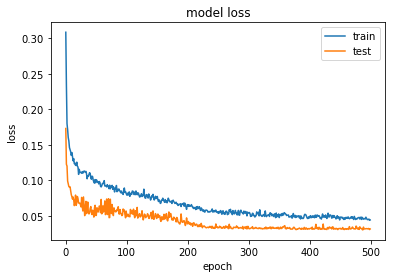

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

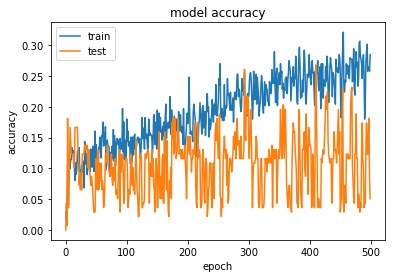

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

In [23]:
test_X, test_y = create_tensors(df_test, h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])
prediction = model.predict(test_X)

In [24]:
test_X.shape

(179, 24, 1)

In [25]:
yHat = scaler.inverse_transform(prediction).reshape(prediction.shape[0] * prediction.shape[1])
y = scaler.inverse_transform(test_y).reshape(prediction.shape[0] * prediction.shape[1])

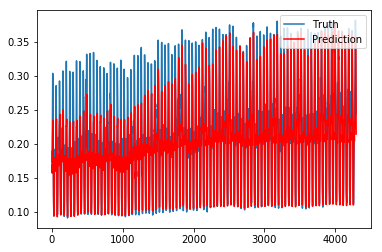

In [26]:
plt.plot(y)
plt.plot(yHat, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.show()

In [27]:
mape = np.mean(np.abs((yHat - y) / y )) * 100
smape = np.mean(np.abs((yHat - y) / (np.abs(y) + np.abs(yHat)) )) * 100
print("MAPE: %.2f SMAPE: %.2f" % (mape, smape))

MAPE: 8.44 SMAPE: 4.44
